In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import pandas as pd
import seaborn as sns
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Data Sets
1. AT&T faces (Modified)
2. Omniglot (Single language - Gujarati)

In [2]:
dataset = 2
# Load the training dataset
if dataset == 1:
    folder_dataset = datasets.ImageFolder(root=r"data\faces\training")
    folder_dataset_test = datasets.ImageFolder(root=r"data\faces\testing/")
    print(f"Dataset: AT&T faces (Modified)\n")
elif dataset == 2:
    folder_dataset = datasets.ImageFolder(root=r"data\Gujarati\training")
    folder_dataset_test = datasets.ImageFolder(root=r"data\Gujarati\testing/")
    print(f"Dataset: Omniglot (Single language - Gujarati)\n")

d_no_epochs = 25
d_batch_size = 30
d_margin = 2.0
d_latent = 2
print(f"Summary of Training Folder:\n {folder_dataset}\n")
print(f"Summary of Testing Folder:\n {folder_dataset_test}")

# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                        transforms.ToTensor()
                                        ])

Dataset: Omniglot (Single language - Gujarati)

Summary of Training Folder:
 Dataset ImageFolder
    Number of datapoints: 760
    Root location: data\Gujarati\training

Summary of Testing Folder:
 Dataset ImageFolder
    Number of datapoints: 200
    Root location: data\Gujarati\testing/


In [3]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

Siamese Neural Network: CNN + FC

In [4]:
#create the Siamese Neural Network
torch.manual_seed(101)
class SiameseNetwork(nn.Module):

    def __init__(self,latent):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,latent)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [5]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        random.seed(42)
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] == img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

Sample batch visualization

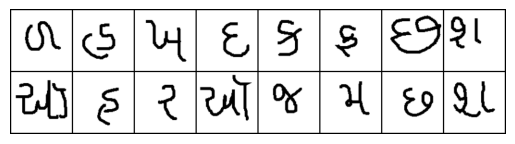

[0. 1. 0. 0. 0. 0. 1. 1.]


In [6]:
# Initialize the network
siamese_dataset_train = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset_train,
                        shuffle=True,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [7]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=d_margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                    (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [8]:
siamese_dataset_train = SiameseNetworkDataset(imageFolderDataset=folder_dataset, transform=transformation)
train_dataloader = DataLoader(siamese_dataset_train, shuffle=True, batch_size=d_batch_size)
net = SiameseNetwork(d_latent).to(device)
criterion = ContrastiveLoss(d_margin)
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

In [9]:
counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(d_no_epochs):
    running_loss = 0.0
    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader):

        # Send the images and labels to CUDA
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()
        running_loss += loss_contrastive.item()
        # Print the loss every 10 batches
        if (i + 1) % len(train_dataloader) == 0:
            print(f"Epoch [{epoch+1}/{d_no_epochs}], Batch [{i+1}/{len(train_dataloader)}], Loss: {running_loss / len(train_dataloader)}")
            running_loss = 0.0
        
        iteration_number += 1
        
        loss_history.append(loss_contrastive.item())
        counter.append(iteration_number)

Epoch [1/25], Batch [26/26], Loss: 1.2178154908693755
Epoch [2/25], Batch [26/26], Loss: 0.7278531010334308
Epoch [3/25], Batch [26/26], Loss: 0.675442445736665
Epoch [4/25], Batch [26/26], Loss: 0.5571550807127585
Epoch [5/25], Batch [26/26], Loss: 0.5125690114039642
Epoch [6/25], Batch [26/26], Loss: 0.5044931935576292
Epoch [7/25], Batch [26/26], Loss: 0.5158460174615567
Epoch [8/25], Batch [26/26], Loss: 0.4812574489758565
Epoch [9/25], Batch [26/26], Loss: 0.43655488238884854
Epoch [10/25], Batch [26/26], Loss: 0.4926816832560759
Epoch [11/25], Batch [26/26], Loss: 0.4681732345085878
Epoch [12/25], Batch [26/26], Loss: 0.4384058295534207
Epoch [13/25], Batch [26/26], Loss: 0.43046013838969743
Epoch [14/25], Batch [26/26], Loss: 0.371284612096273
Epoch [15/25], Batch [26/26], Loss: 0.35672125965356827
Epoch [16/25], Batch [26/26], Loss: 0.37500783571830165
Epoch [17/25], Batch [26/26], Loss: 0.33954570155877334
Epoch [18/25], Batch [26/26], Loss: 0.3531028164120821
Epoch [19/25], B

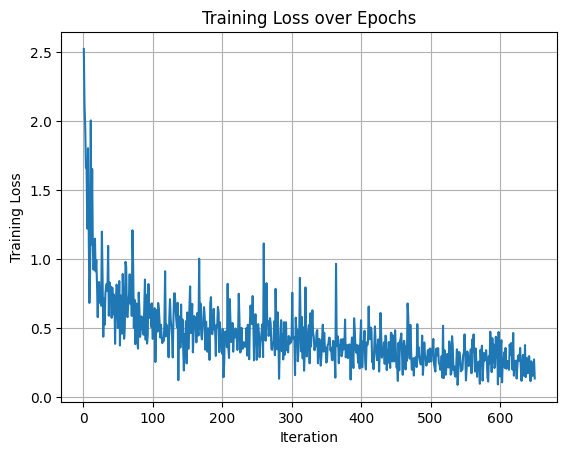

In [10]:
plt.plot(counter, loss_history)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

Training result visualization

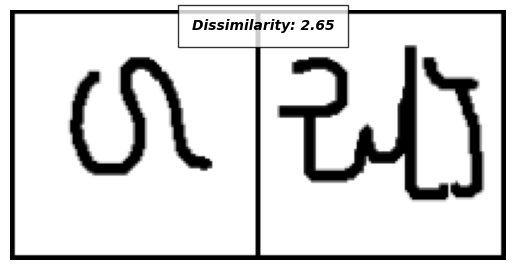

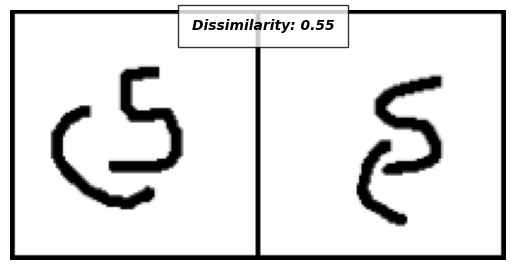

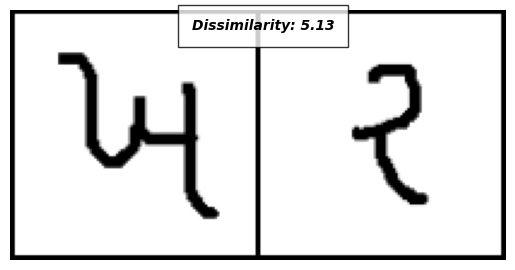

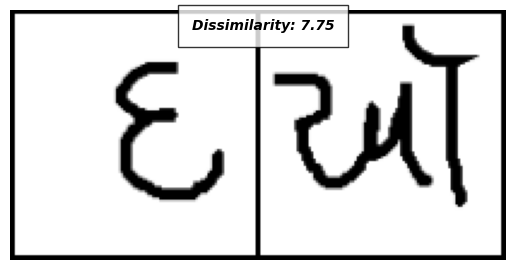

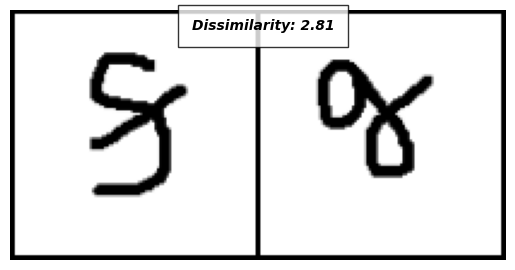

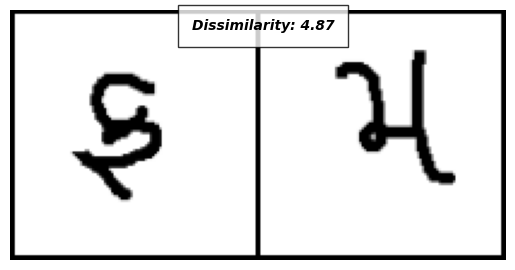

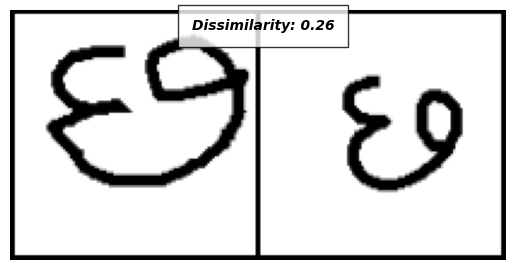

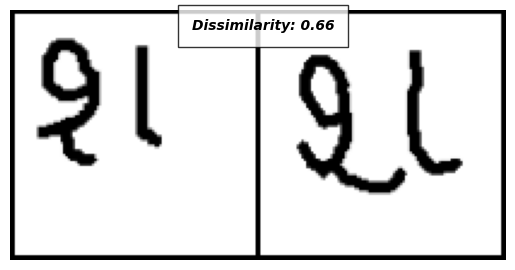

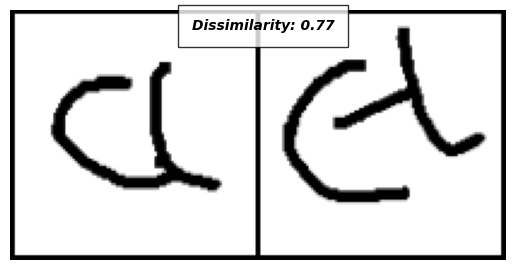

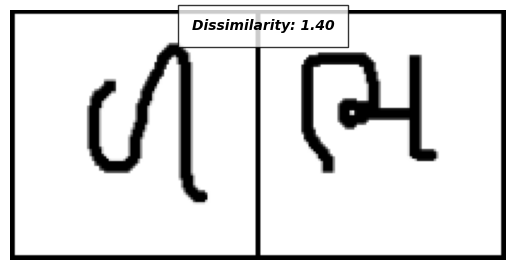

In [11]:
# Locate the test dataset and load it into the SiameseNetworkDataset
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset, transform=transformation)
train_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(train_dataloader)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    x0, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.to(device), x1.to(device))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

Defining the threshold by data distribution of similar and dissimilar distance for classification

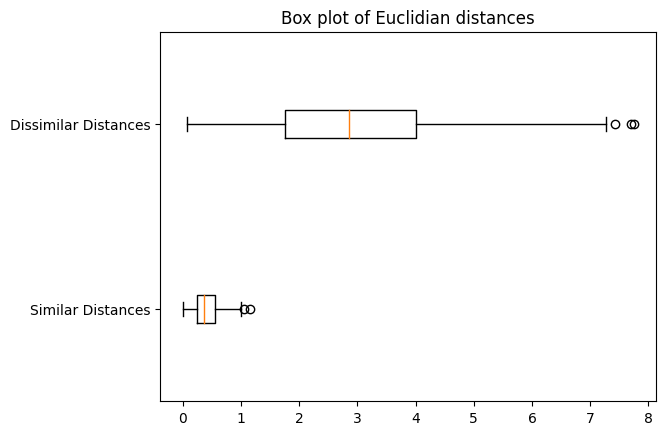

In [12]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)
train_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)

# Test loop
with torch.no_grad():
    net.eval()
    train_distance = []
    train_label = []
    
    for input1, input2, label in train_dataloader:
        train_label.append(int(label.item()))
        input1, input2, label = input1.to(device), input2.to(device), label.to(device)

        output1,output2 = net(input1, input2)
        distance = F.pairwise_distance(output1,output2)
        train_distance.append(distance.detach().cpu())

train_distance = np.array([x.item() for x in train_distance])
train_label = np.array(train_label)
train_similar = np.where(train_label==1)[0]
similar_dist = np.array([train_distance[i] for i in train_similar])
train_dissimilar = np.where(train_label==0)[0]
dissimilar_dist = np.array([train_distance[i] for i in train_dissimilar])
threshold = np.percentile(similar_dist, 87.5)

data = [similar_dist, dissimilar_dist]
fig,ax=plt.subplots()
ax.boxplot(data, vert = False, labels= ['Similar Distances','Dissimilar Distances'])
plt.title('Box plot of Euclidian distances')
plt.show()

In [13]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)

# Test loop
with torch.no_grad():
    net.eval()
    test_loss = []
    test_label = []
    correct = 0
    
    for input1, input2, label in test_dataloader:
        test_label.append(int(label.item()))
        input1, input2, label = input1.to(device), input2.to(device), label.to(device)

        output1,output2 = net(input1, input2)
        loss = F.pairwise_distance(output1,output2)
        test_loss.append(loss.detach().cpu())
        
test_loss = np.array([x.item() for x in test_loss])
test_label = np.array(test_label)
pred_label = [1 if x < threshold else 0 for x in test_loss]
for i in range(len(test_label)):
    if pred_label[i]  == test_label[i]:
        correct += 1
print(f"Threshold: {threshold} \nAccuracy = {100*(correct/len(test_label))}%")

Threshold: 0.6485291719436646 
Accuracy = 69.5%


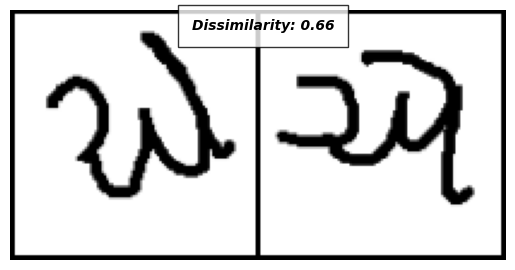

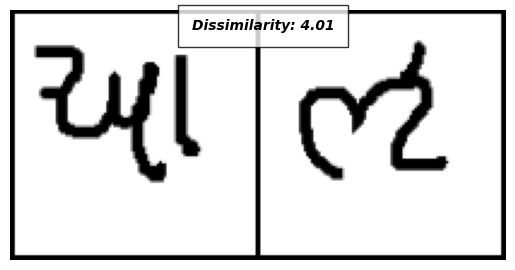

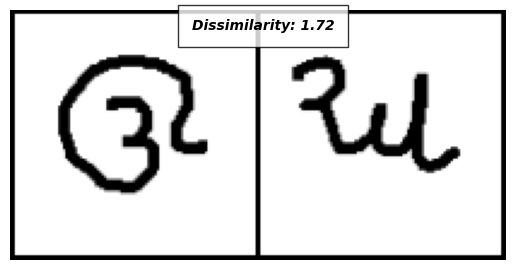

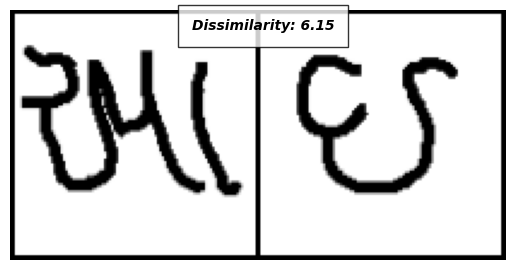

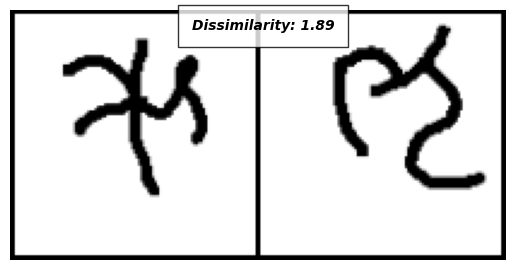

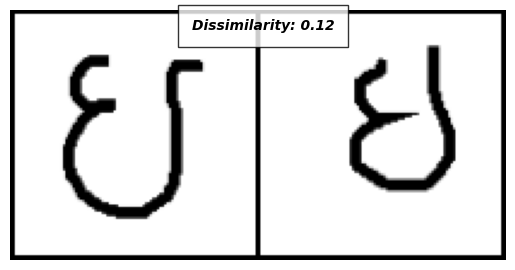

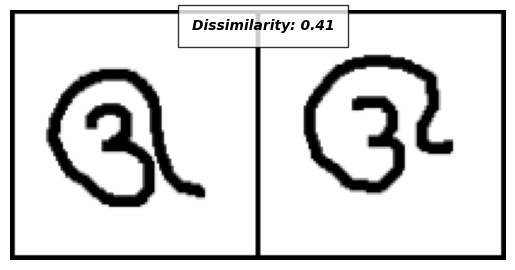

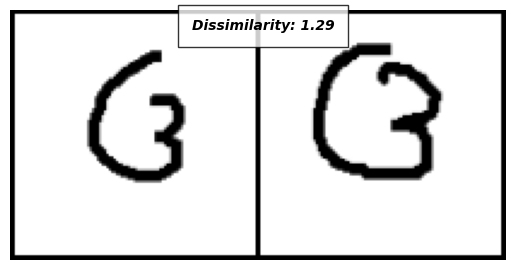

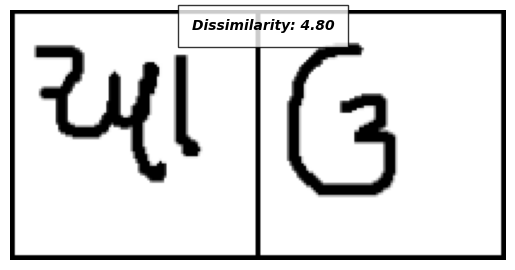

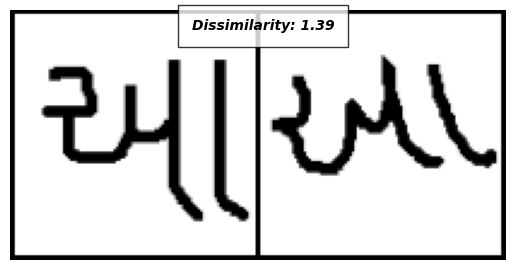

In [14]:
# Locate the test dataset and load it into the SiameseNetworkDataset
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test, transform=transformation)
test_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    x0, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.to(device), x1.to(device))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')